# Plot noise 

author: steeve.laquitaine@epfl.ch  
date: 09.01.2024

**purpose**: characterize sorting in ideal, no external noise, condition.

### Data Description 

**in-vivo**:

* `Marques` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 30.0kHz
    * 20.25 min
    * "Spontaneous activity" (Only anesthetized condition)
    
**in-silico**:

* `Neuropixels` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 40.0kHz
    * 10 min
    * "Spontaneous activity" (Only anesthetized condition)


### Summary

* In vivo traces' mean were removed, so we removed the mean from each recording site in silico.
* We fitted in silico preprocessed traces to in vivo preprocessed traces to match the 1) max voltage amplitude and 2) the average background noises per layer (minimum mean absolute deviation). The missing noise was modelled as independent noise on each site.
* The raw silico traces will be scaled and the missing noise added for all subsequent analyses.
* **failed approaches**:
    * applying the scale and missing gaussian noise fitted with preprocessed traces on the raw traces then preprocessing the transformed silico traces, in that order, produces smaller noises per layer than observed in vivo, because high-pass filtering and common referencing remove noise from the traces.
    * rescaling and adding Gaussian noise must be applied to the raw traces, which should then be preprocessed, during each iteration of the fitting procedure. Because the preprocessing of the entire recording is computationally expansive (15 min for 10 min recording), we fitted noise and scale on the first 10 seconds of the in silico recording.

### Prerequisites

run the processing pipeline

### Setup libs

Activate `spikeinterf..` venv

In [3]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
from concurrent.futures import ProcessPoolExecutor
import copy
import spikeinterface.extractors as se
from scipy.optimize import minimize
import spikeinterface.full as si_full
from contextlib import redirect_stdout
from csv import writer
import seaborn as sns

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.dataeng.silico import recording, probe_wiring
from src.nodes.prepro import preprocess
from src.nodes.study.layer import getAtlasInfo
from src.nodes.dataeng.silico.probe_wiring import wire_silico_marques_probe

# SETUP PARAMETERS
RND_SEED = 0                # random seed
SFREQ_VIVO = 30000          # sampling frequency
SFREQ_SILICO = 40000        # sampling frequency
WIND_END = 3700             # last segment to calculate mad

# vivo
data_conf_h_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values() 
RAW_PATH_h_vivo = data_conf_h_vivo["raw"]
PREP_PATH_h_vivo = data_conf_h_vivo["preprocessing"]["output"]["trace_file_path"]
CONTACTS_h = np.arange(0,128,1)

# silico
data_conf_h_silico, param_conf_h_silico = get_config("silico_neuropixels", "concatenated").values()
PREP_PATH_h_silico = data_conf_h_silico["preprocessing"]["output"]["trace_file_path_noise_0uV"]
BLUECONFIG = data_conf_h_silico["dataeng"]["blueconfig"]

# FIGURE SETTINGS
COLOR_VIVO = (0.25, 0.25, 0.25)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.99215686, 0.68235294, 0.38039216)

BOX_ASPECT = 1                  # square fig
FIG_SIZE = (4,4)
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 18
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 1
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-05-07 12:41:19,453 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-07 12:41:19,475 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-05-07 12:41:19,476 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-07 12:41:19,502 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Define custom functions

In [4]:
def measure_trace_noise(traces, sfreq, wind_end):
    """measure noise (mean absolute deviation)
    at consecutive segments of 1 second

    Args:
        traces: 2D array
    """
    winds = np.arange(0, wind_end, 1)
    mads = []
    for wind_i in winds:
        segment = traces[wind_i * sfreq : (wind_i + 1) * sfreq]
        mads.append(pd.DataFrame(segment).mad().values[0])
    return mads


def measure_vivo_trace_noise_parallel(traces_vivo, site):
    """Measure the minimum absolute deviation of a single trace
    over contiguous segments of one second
    "Site" is only used implicitly to pass each row of the
    traces_vivo matrix (the original timepoints x site matrix was transposed
    such that sites are in rows) to this function.

    Args:
        traces_vivo (np.array): a 1D trace array of site x timepoints
        site (int): the row used to implicitely extract that row from traces_vivo

    Returns:
        _type_: _description_
    """
    # each site row of the array is passed to a worker
    return min(measure_trace_noise(traces_vivo, SFREQ_VIVO, WIND_END))


def measure_silico_trace_noise_parallel(traces_silico, site):
    """Measure the minimum absolute deviation of a single trace
    over contiguous segments of one second
    "Site" is only used implicitly to pass each row of the
    traces_vivo matrix (the original timepoints x site matrix was transposed
    such that sites are in rows) to this function.

    Args:
        traces_silico (np.array): a 1D trace array of site x timepoints
        site (int): the row used to implicitely extract that row from traces_vivo

    Returns:
        _type_: _description_
    """
    # each site row of the array is passed to a worker
    return min(measure_trace_noise(traces_silico, SFREQ_SILICO, WIND_END))


def sem(data):
    return np.std(data) / np.sqrt(len(data))


def conf_interv95(data):
    return 1.96 * sem(data)


def get_layer_sites(silico_layers, layer: str = "L1"):
    if layer == "L2_3":
        return np.hstack(
            [np.where(silico_layers == "L2")[0], np.where(silico_layers == "L3")[0]]
        )
    else:
        return np.where(silico_layers == layer)[0]

### (73m)Compute noise

In [5]:
# 1. load recordings --------------
2165683
# - get vivo traces
PreRecording_h_vivo = si.load_extractor(PREP_PATH_h_vivo)
traces_vivo = PreRecording_h_vivo.get_traces()

# - get silico traces
PreRecording_h_silico = si.load_extractor(PREP_PATH_h_silico)
traces_silico = PreRecording_h_silico.get_traces()

# 2. Compute layer-wise noise (13 mins) --------------

# VIVO
# measure site noise of in vivo traces (parallelized, )
with ProcessPoolExecutor() as executor:
    noise_by_trace = executor.map(
        measure_vivo_trace_noise_parallel,
        traces_vivo.T,
        np.arange(0, traces_vivo.shape[1], 1),
    )
vivo_noise_by_trace = list(noise_by_trace)

# SILICO
# measure site noise of fitted silico traces
with ProcessPoolExecutor() as executor:
    silico_noise_by_trace = executor.map(
        measure_silico_trace_noise_parallel,
        traces_silico.T,
        np.arange(0, traces_silico.shape[1], 1),
    )
silico_noise_by_trace = list(silico_noise_by_trace)

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/binaryrecordingextractor.py:78: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")


### Plot noise

/tmp/ipykernel_195277/3746155312.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


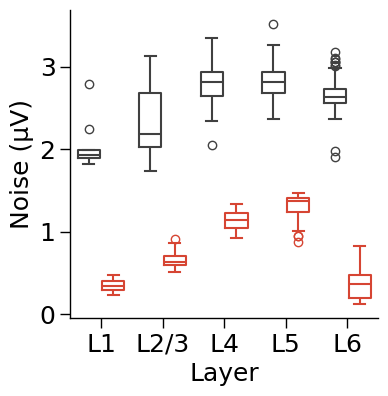

In [6]:
# FORMAT PLOT DATA ----------

layers = ["L1", "L2_3", "L4", "L5", "L6"]

# - get site layers
vivo_layers = PreRecording_h_vivo.get_property("layers")
silico_layers = PreRecording_h_silico.get_property("layers")

vivo_noise = []
sili_noise = []

# calculate noise stats by layer
for l_i in range(len(layers)):
    # VIVO
    vivo_noise.append(np.array(vivo_noise_by_trace)[vivo_layers == layers[l_i]])

    # SILICO
    sites = get_layer_sites(silico_layers, layer=layers[l_i])
    sili_noise.append(np.array(silico_noise_by_trace)[sites])

# build dataset to plot
# - vivo data
vivo_data = pd.DataFrame(data=np.array(vivo_noise_by_trace), columns=["noise"])
vivo_data["layer"] = vivo_layers
vivo_data["experiment"] = "vivo"

# - silico data
sili_data = pd.DataFrame(data=np.array(silico_noise_by_trace), columns=["noise"])

# - group l2 and l3
new_silico_layers = copy.copy(silico_layers)
new_silico_layers[new_silico_layers == "L2"] = "L2_3"
new_silico_layers[new_silico_layers == "L3"] = "L2_3"
sili_data["layer"] = new_silico_layers
sili_data["experiment"] = "silico"

plot_data = pd.concat([vivo_data, sili_data], ignore_index=True)

# drop sites outside layers
mask = np.isin(plot_data["layer"], layers)
plot_data = plot_data[mask]
plot_data = plot_data.sort_values(by=["layer"])


# PLOT ----------

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="noise",
    hue="experiment",
    fill=False,
    hue_order=["vivo", "silico"],
    palette=[COLOR_VIVO, COLOR_SILI],
    gap=0.1,
    linewidth=1.5,
)
ax.spines[["top", "right"]].set_visible(False)
# ax.legend(frameon=LG_FRAMEON)
ax.legend("", frameon=False)
ax.set_ylabel("Noise (\u03bcV)")
ax.set_xlabel("Layer")
ax.set_box_aspect(BOX_ASPECT)  # square axis
ax.set_xticklabels(
    [
        "L1",
        "L2/3",
        "L4",
        "L5",
        "L6",
    ]
)

# save figures
plt.savefig(
    "figures/2_realism/2_noise/pdf/layerwise_noise_stats_marques_40m_buttw_noise_0uV.pdf",
    bbox_inches="tight",
)
plt.savefig(
    "figures/2_realism/2_noise/svg/layerwise_noise_stats_marques_40m_buttw_noise_0uV.svg",
    bbox_inches="tight",
)